# STYLEGAN2-ADA


In [1]:
import generate_nb
import matplotlib.pyplot as plt
import torch
import numpy as np
import dnnlib
import legacy
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import importlib
from sklearn.manifold import TSNE
import projector_nb
import numpy as np
import torch
import os

from tqdm import tqdm
import generate_nb
import matplotlib.pyplot as plt
import torch
import numpy as np
import dnnlib
import legacy
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import importlib

import projector_nb
importlib.reload(projector_nb)
import numpy as np
import torch
import os
import imageio
from tqdm import tqdm
import matplotlib.pyplot as plt

from joblib import dump, load
from sklearn.decomposition import KernelPCA
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

In [2]:
import sys
print(sys.version)


3.11.9 (main, Apr 19 2024, 16:48:06) [GCC 11.2.0]


test pca

In [3]:
network = "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"
device = "cpu"

In [4]:
with dnnlib.util.open_url(network) as fp:
        G = legacy.load_network_pkl(fp)['G_ema'].requires_grad_(False).to(device)

In [6]:
def generate_samples(G, num_samples):
    z_samples = np.random.RandomState().randn(num_samples, 512).astype(np.float32) 
    
    w_samples = G.mapping(torch.from_numpy(z_samples).to(device), None)  # [N, L, C]
    w_samples = w_samples.cpu().numpy()
    w_samples = w_samples[:,0,:]

    return w_samples

def get_pca(samples,ncomp):
    
    scaler = StandardScaler()
    samples_scaled = scaler.fit_transform(samples)  

    pca = PCA(n_components=ncomp)
    pca.fit(samples_scaled)

    explained_variance = pca.explained_variance_ratio_
    cumulative_explained_variance = np.cumsum(explained_variance)

    # Plot explained variance
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.5, align='center',
        label='Individual Explained Variance')
    plt.step(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, where='mid',
         label='Cumulative Explained Variance')

    plt.xlabel('Principal Component Index')
    plt.ylabel('Explained Variance Ratio')
    plt.title('PCA Explained Variance')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

    return pca , scaler

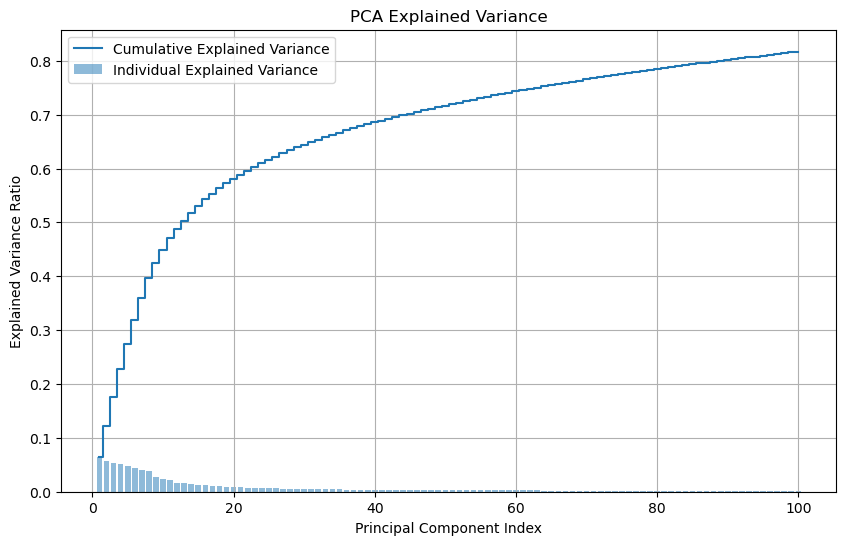

In [7]:
w_samples = generate_samples(G, 10000)
pca , scaler = get_pca(w_samples,ncomp=100)

In [8]:
def move_according_to_component(G, device, pca, outdir, directions,  layers, num_steps, save_video=True, title_vid = 'proj', random_seed=None):
    os.makedirs(outdir, exist_ok=True)

    if random_seed is not None:
        np.random.seed(random_seed)

    explained_variance = pca.explained_variance_
    V = pca.components_.T
   
    # Generate a random z vector
    #z_sample = np.random.RandomState().randn(1, 512).astype(np.float32)  # select a random z vector
    z_sample = np.random.RandomState(random_seed).randn(1, 512).astype(np.float32) 
    w_sample = G.mapping(torch.from_numpy(z_sample).to(device), None)

    # Generate the original image
    img_original = G.synthesis(w_sample, noise_mode='const')
    img_original = (img_original + 1) * (255 / 2)
    img_original = img_original.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()
    '''
    plt.imshow(img_original)
    plt.title('Original image')
    plt.axis('off')
    plt.show()
    '''

    # Convert w_sample to numpy and select the second element in the latent vector (w space)
    w_sample = w_sample.cpu().numpy()
    w_sample = w_sample[:, 1, :]  
    w_sample = scaler.transform(w_sample)

    img_list = []
    w_list = []

    # Initialize x
    x = np.zeros((V.shape[1], 1))
    X =  np.tile(x, (1, num_steps))

    # We use X to store the variations according to the selected dimension in one matrix 
    # as we dont move the same way on each direction

    for v in directions:
        sigma = np.sqrt(explained_variance[v])
        start_value = -2* sigma
        end_value = 2* sigma
        arrays_between = np.linspace(start_value, end_value, num_steps + 2)[1:-1]
        X[v] = arrays_between
    
   
    # each line of X correspond to a direction, the columns represent the range from -2 sigma
    # to 2 sigma
    # So the vector x of the article is one of the column of X
    
    # X.shape[0] is the number of componets
    # X.shape[1] is the number of steps from -2 sigma to 2 sigma
    
    for i in range(X.shape[1]):
        x_tmp = X[:,i]
        movement = V @ x_tmp
        movement = np.expand_dims(movement, axis=1)
      
        w_new = w_sample.T + movement
        w_new = w_new.T
        w_new = scaler.inverse_transform(w_new)
        W = np.tile(scaler.inverse_transform(w_sample), (1, 18, 1))
        W[:,layers,:] = w_new
        w_list.append(W)

    '''
    for scalar in tqdm(arrays_between):
        w_pca = pca.transform(w_sample)
        w_pca[:, component_index] += scalar
        w_new_single = pca.inverse_transform(w_pca)

        w_new = np.tile(w_new_single[:, np.newaxis, :], (1, 18, 1))
        w_list.append(w_new)
    '''
    video = imageio.get_writer(f'{outdir}/{title_vid}.mp4', mode='I', fps=10, codec='libx264', bitrate='16M')
    for w_modified in w_list:
            w_modified_tensor = torch.from_numpy(w_modified).to(device)
            synth_image = G.synthesis(w_modified_tensor, noise_mode='const')
            synth_image = (synth_image + 1) * (255 / 2)
            synth_image = synth_image.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()
            img_list.append(synth_image)
        

    for synthetic_image in img_list:
        video.append_data(np.concatenate([img_original, synthetic_image], axis=1))

    if save_video: 
        print("Editing video ...")
        os.makedirs(outdir, exist_ok=True)
        print(f'Saving optimization progress video "{outdir}/{title_vid}.mp4"')
        
        video.close()
        print("Video saved")
    
    return img_list, X

In [9]:
def plot_results(img_list, X_list, num_images_plot=10):
   
    # Determine the indices of images to plot
    indices = np.linspace(0, len(img_list) - 1, num=num_images_plot, dtype=int)
    
    # Plot the images
    n_cols = 5
    n_rows = (num_images_plot + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
    axes = axes.flatten()

    for i, idx in enumerate(indices):
        axes[i].imshow(img_list[idx])
        axes[i].axis('off')

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

In [10]:
directions = [0]
layers =list(range(0, 18))
img_list_gender , X_list_gender = move_according_to_component(G, device,pca, 'output_directory_pca', directions=directions, layers = layers, num_steps=40,save_video=True, title_vid='tmp',random_seed=2)


plot_results(img_list_gender, X_list_gender)

# PCA Analysis 

---

In [3]:
network = "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"
device = 'cpu'
with dnnlib.util.open_url(network) as fp:
        G = legacy.load_network_pkl(fp)['G_ema'].requires_grad_(False).to(device)

In [4]:
def generate_samples(G, num_samples):
    z_samples = np.random.RandomState().randn(num_samples, 512).astype(np.float32) 
    
    w_samples = G.mapping(torch.from_numpy(z_samples).to(device), None)  # [N, L, C]
    w_samples = w_samples.cpu().numpy()
    w_samples = w_samples[:,0,:]

    return w_samples

def get_pca(samples,ncomp):
    
    scaler = StandardScaler()
    samples_scaled = scaler.fit_transform(samples)  

    pca = PCA(n_components=ncomp)
    pca.fit(samples_scaled)

    explained_variance = pca.explained_variance_ratio_
    cumulative_explained_variance = np.cumsum(explained_variance)

    # Plot explained variance
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.5, align='center',
        label='Individual Explained Variance')
    plt.step(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, where='mid',
         label='Cumulative Explained Variance')

    plt.xlabel('Principal Component Index')
    plt.ylabel('Explained Variance Ratio')
    plt.title('PCA Explained Variance')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

    return pca , scaler



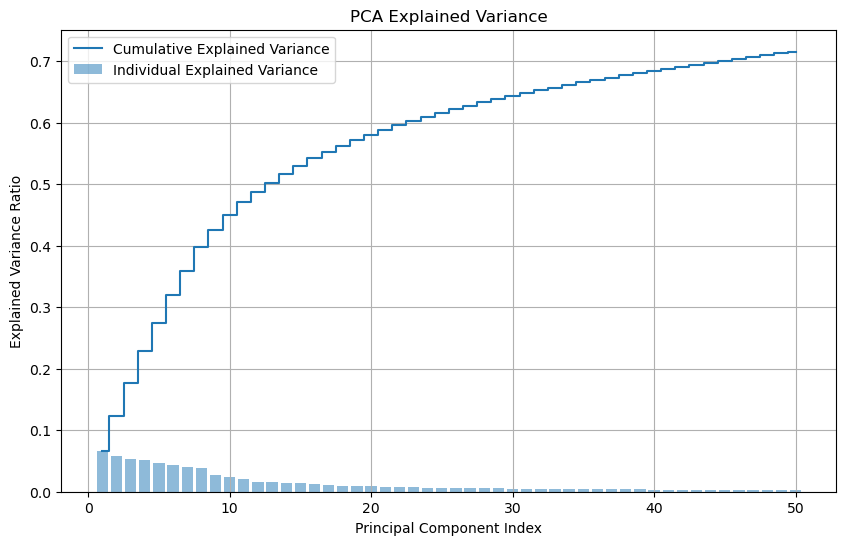

In [11]:
w_samples = generate_samples(G, 50000)
pca , scaler = get_pca(w_samples,ncomp=50)

**Visualisation of data with TSNE**

The TSNE is a tool to visual high dimensional data, we will proejct the data in the first 50 components   to reduce first the dimension.


In [5]:
w_samples_new = generate_samples(G, 10000)
w_scaled = scaler.transform(w_samples_new)
w_projected = pca.transform(w_scaled)

- Projection in PCA first

In [6]:
W_embedded_pca = TSNE(n_components=2, learning_rate=10,init='pca',verbose=2, perplexity=3).fit_transform(w_projected)

[t-SNE] Computing 10 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.001s...
[t-SNE] Computed neighbors for 10000 samples in 0.214s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 2.780496
[t-SNE] Computed conditional probabilities in 0.038s
[t-SNE] Iteration 50: error = 121.6620865, gradient norm = 0.0000215 (50 iterations in 4.372s)
[t-SNE] I

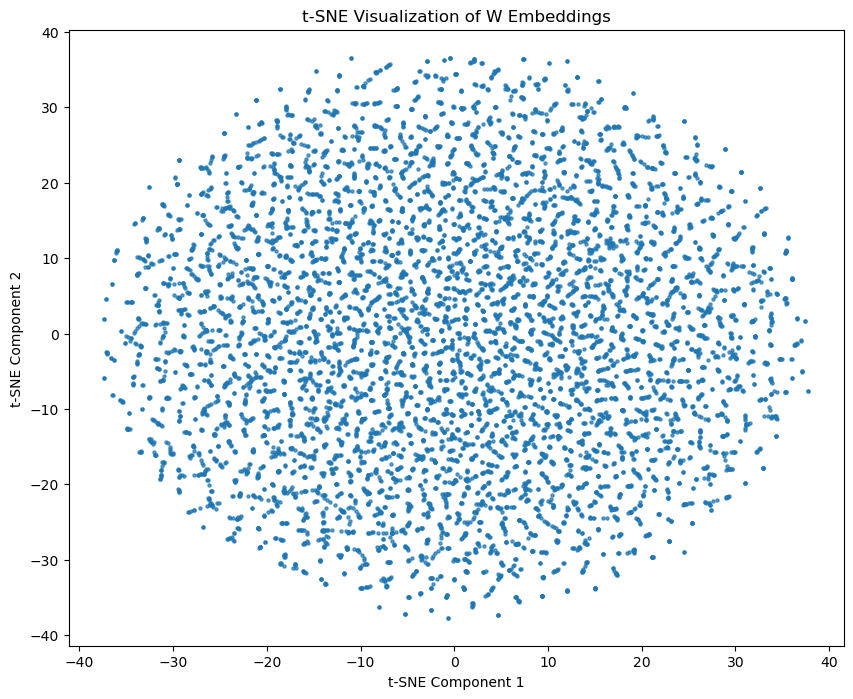

In [7]:
# Assuming W_embedded_pca is your 2D embedded data

plt.figure(figsize=(10, 8))
plt.scatter(W_embedded_pca[:, 0], W_embedded_pca[:, 1], s=5, alpha=0.7)
plt.title('t-SNE Visualization of W Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


In [8]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=)
kmeans.fit(w_projected)
cluster_labels = kmeans.labels_

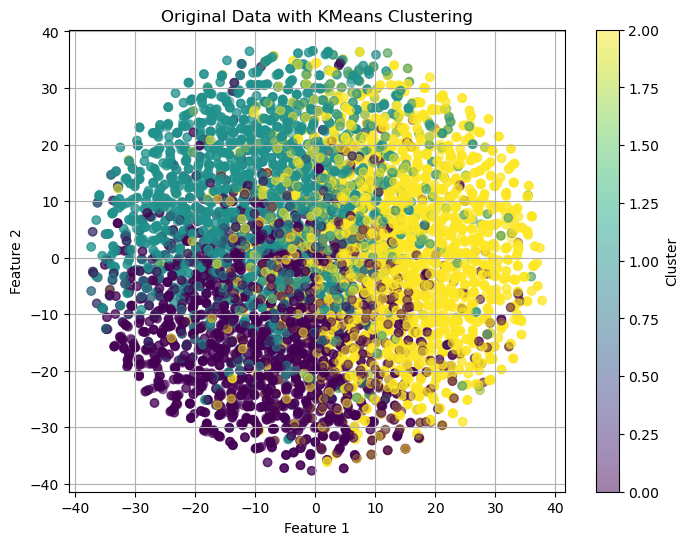

In [9]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans


# Visualize clusters
plt.figure(figsize=(8, 6))
plt.scatter(W_embedded_pca[:, 0], W_embedded_pca[:, 1], c=cluster_labels, cmap='viridis', alpha=0.5)
plt.colorbar(label='Cluster')
plt.title('Original Data with KMeans Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.grid(True)
plt.show()

In [36]:
# Visualize the embeddings in 3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(W_embedded_pca_3[:, 0], W_embedded_pca_3[:, 1], W_embedded_pca_3[:, 2],c=cluster_labels, cmap='viridis', alpha=0.5)
ax.set_title('t-SNE Visualization of W Embeddings (3D)')
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_zlabel('t-SNE Component 3')
plt.show()

<IPython.core.display.Javascript object>

In [6]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5)
kmeans.fit(w_samples_new)
cluster_labels = kmeans.labels_

# VAE training

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import numpy as np
import generate_nb
import matplotlib.pyplot as plt
import torch
import numpy as np
import dnnlib
import legacy
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import importlib

import projector_nb
importlib.reload(projector_nb)
import numpy as np
import torch
import os
import imageio
from tqdm import tqdm
import matplotlib.pyplot as plt

from joblib import dump, load
from sklearn.decomposition import KernelPCA
from sklearn.metrics.pairwise import cosine_similarity

In [8]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim * 2)  # 2 for mean and variance
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )
    
    def encode(self, x):
        h = self.encoder(x)
        mean, log_var = torch.chunk(h, 2, dim=1)
        return mean, log_var
    
    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mean + eps * std
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mean, log_var = self.encode(x)
        z = self.reparameterize(mean, log_var)
        x_recon = self.decode(z)
        return x_recon, mean, log_var


In [9]:
network = "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with dnnlib.util.open_url(network) as fp:
        G = legacy.load_network_pkl(fp)['G_ema'].requires_grad_(False).to(device)

In [12]:
def loss_function(recon_x, x, mean, log_var):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return BCE + KLD

# Parameters
input_dim = 512
hidden_dim = 256
latent_dim = 20
batch_size = 64
epochs = 20
learning_rate = 1e-3


scaler = StandardScaler()
w_samples = generate_samples(G, 5000)
w_samples_normalized = scaler.fit_transform(w_samples)

# Min-max scaling to [0, 1]
min_val = w_samples_normalized.min()
max_val = w_samples_normalized.max()
w_samples_scaled = (w_samples_normalized - min_val) / (max_val - min_val)

In [13]:
# Create DataLoader
dataset = TensorDataset(torch.tensor(w_samples_scaled, dtype=torch.float32))
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize model and optimizer
vae = VAE(input_dim, hidden_dim, latent_dim).to(device)
optimizer = optim.Adam(vae.parameters(), lr=learning_rate)

# Training loop
for epoch in range(epochs):
    for data in dataloader:
        x = data[0].to(device)
        x_recon, mean, log_var = vae(x)
        loss = loss_function(x_recon, x, mean, log_var)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch {epoch + 1}, Loss: {loss.item()}')

print("Training complete.")

torch.save(vae.state_dict(), 'vae_model_tmp.pth')

Epoch 1, Loss: 2321.821044921875
Epoch 2, Loss: 2298.7275390625
Epoch 3, Loss: 2325.990234375
Epoch 4, Loss: 2317.9462890625
Epoch 5, Loss: 2294.976318359375
Epoch 6, Loss: 2296.951904296875
Epoch 7, Loss: 2296.75439453125
Epoch 8, Loss: 2293.18310546875
Epoch 9, Loss: 2300.7265625
Epoch 10, Loss: 2297.20556640625
Epoch 11, Loss: 2302.501953125
Epoch 12, Loss: 2303.346435546875
Epoch 13, Loss: 2301.15576171875
Epoch 14, Loss: 2289.22265625
Epoch 15, Loss: 2296.740478515625
Epoch 16, Loss: 2299.962158203125
Epoch 17, Loss: 2312.10009765625
Epoch 18, Loss: 2305.271728515625
Epoch 19, Loss: 2287.6240234375
Epoch 20, Loss: 2286.017822265625
Training complete.


# AE training

In [10]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim,hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim,hidden_dim),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )
    
    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        z = self.encode(x)
        x_recon = self.decode(z)
        return x_recon

In [11]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Define loss function
def loss_function(recon_x, x):
    return nn.functional.mse_loss(recon_x, x)

# Parameters
input_dim = 512
hidden_dim = 512
latent_dim = 512
batch_size = 16
epochs = 15
learning_rate = 1e-2

w_samples_ae = generate_samples(G, 1000)


# Define your data preprocessing pipeline
preprocessing_pipeline = Pipeline([
    ('minmax', MinMaxScaler()),
    ('standard', StandardScaler())
])

# Example usage: Fit and transform data
w_samples_scaled = preprocessing_pipeline.fit_transform(w_samples_ae)

# Example usage: Inverse transform
w_samples_original_scale = preprocessing_pipeline.inverse_transform(w_samples_scaled)



scaler = StandardScaler()

w_samples_normalized = scaler.fit_transform(w_samples_ae)

# Min-max scaling to [0, 1]
min_val = w_samples_normalized.min()
max_val = w_samples_normalized.max()
w_samples_scaled = (w_samples_normalized - min_val) / (max_val - min_val)

# Create DataLoader
dataset = TensorDataset(torch.tensor(w_samples_scaled, dtype=torch.float32))
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize model and optimizer
ae = Autoencoder(input_dim, hidden_dim, latent_dim).to(device)

optimizer = optim.Adam(ae.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)


patience = 10  # Number of epochs to wait for improvement
threshold = 0.005  # Threshold for significant loss increase
best_loss = float('inf')
patience_counter = 0

# Training loop
for epoch in range(epochs):
    ae.train()
    train_loss = 0
    for data in dataloader:
        x = data[0].to(device)
        x_recon = ae(x)

        loss = loss_function(x_recon, x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(dataloader)
    
    ae.eval()
    val_loss = 0
    with torch.no_grad():
        for data in dataloader:
            inputs = data[0]
            outputs = ae(inputs)
            loss = loss_function(outputs, inputs)
            val_loss += loss.item()
    
    print(f'Epoch {epoch + 1}, Loss: {loss.item()}')
    scheduler.step(val_loss)
    # Check for early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0
    elif val_loss > best_loss + threshold:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break
    else:
        patience_counter = 0

print("Training complete.")

torch.save(ae.state_dict(), 'autoencoder_model.pth')

/home/koko/anaconda3/envs/stylegan_env/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1, Loss: 0.2671801745891571
Epoch 2, Loss: 0.26790690422058105
Epoch 3, Loss: 0.27210843563079834
Epoch 4, Loss: 0.2678033411502838
Epoch 5, Loss: 0.26910683512687683
Epoch 6, Loss: 0.26865440607070923
Epoch 7, Loss: 0.26627612113952637
Epoch 8, Loss: 0.2686614394187927
Epoch 9, Loss: 0.2719833254814148
Epoch 10, Loss: 0.2697424590587616
Epoch 11, Loss: 0.27066147327423096
Epoch 12, Loss: 0.2674686908721924
Epoch 13, Loss: 0.26960259675979614
Epoch 14, Loss: 0.2696908116340637
Epoch 15, Loss: 0.2685107886791229
Training complete.


In [13]:
def encode_decode_sample(vae, scaler, sample):
    vae.eval()
    
    # Preprocess the sample
    sample = scaler.transform(sample.reshape(1, -1))  # Reshape and scale
    
    sample_tensor = torch.tensor(sample, dtype=torch.float32).to(device)
    
    # Encode the sample
    with torch.no_grad():
        z = vae.encode(sample_tensor)
    
    # Decode the latent code
    with torch.no_grad():
        reconstructed_sample = vae.decode(z)
    
    reconstructed_sample = reconstructed_sample.cpu().numpy()
    reconstructed_sample = scaler.inverse_transform(reconstructed_sample)  # Inverse transform
    
    return reconstructed_sample.reshape(-1)  # Flatten back to original shape



In [14]:
z_sample = np.random.RandomState(2).randn(1, 512).astype(np.float32) 
w_sample = G.mapping(torch.from_numpy(z_sample).to(device), None)

# Generate the original image
img_original = G.synthesis(w_sample, noise_mode='const')
img_original = (img_original + 1) * (255 / 2)
img_original = img_original.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()


# Convert w_sample to numpy and select the second element in the latent vector (w space)
w_sample = w_sample.cpu().numpy()
w_sample = w_sample[:, 1, :]  

reconstructed_sample = encode_decode_sample(ae, scaler, w_sample)

euclidean_distance_2sigma = np.linalg.norm(w_sample - reconstructed_sample)
print(euclidean_distance_2sigma)

11.08579


In [ ]:
W_or= np.tile(scaler.inverse_transform(w_sample), (1, 18, 1))
W_or_tensor = torch.tensor(W_or, dtype=torch.float32).to(device)
img_original = G.synthesis(W_or_tensor, noise_mode='const')
img_original = (img_original + 1) * (255 / 2)
img_original = img_original.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()

plt.imshow(img_original)

In [ ]:
W_or= np.tile(scaler.inverse_transform(reconstructed_sample), (1, 18, 1))
W_or_tensor = torch.tensor(W_or, dtype=torch.float32).to(device)
img_original = G.synthesis(W_or_tensor, noise_mode='const')
img_original = (img_original + 1) * (255 / 2)
img_original = img_original.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()

plt.imshow(img_original)

# beta VAE PCA

In [12]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim * 2)  # output both mu and logvar
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()  
        )
    
    def encode(self, x):
        h = self.encoder(x)
        mu, logvar = torch.chunk(h, 2, dim=1)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar, z


In [13]:
def combined_loss(recon_x, x, mu, logvar, z, explained_variance, alpha=0.1, beta=1.0):
    # Reconstruction loss (MSE)
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    
    # Maximize explained variance
    pca_loss = -explained_variance  # We negate because we want to maximize
    
    # KL Divergence loss
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return recon_loss + alpha * pca_loss + beta * kl_loss

In [17]:
# Parameters
input_dim = 512
hidden_dim = 512
latent_dim = 256
batch_size = 32
epochs = 30
learning_rate = 1e-2


w_samples_ae = generate_samples(G, 10000)
scaler = StandardScaler()

w_samples_normalized = scaler.fit_transform(w_samples_ae)

# Min-max scaling to [0, 1]
min_val = w_samples_normalized.min()
max_val = w_samples_normalized.max()
w_samples_scaled = (w_samples_normalized - min_val) / (max_val - min_val)

# Create DataLoader
dataset = TensorDataset(torch.tensor(w_samples_scaled, dtype=torch.float32))
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize model and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vae = VAE(input_dim, hidden_dim, latent_dim).to(device)

optimizer = optim.Adam(vae.parameters(), lr=learning_rate)
alpha= 0.1

# Training loop
for epoch in range(epochs):
    vae.train()
    train_loss = 0
    all_latent_representations = []
    
    for data in dataloader:
        x = data[0].to(device)
        optimizer.zero_grad()
        x_recon, mu, logvar, z = vae(x)
        
        # Collect latent representations
        all_latent_representations.append(z.detach().cpu().numpy())
        
        # Calculate reconstruction loss and KL divergence for the current batch
        recon_loss = nn.functional.mse_loss(x_recon, x, reduction='sum')
        kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        
        # Combine reconstruction and KL loss for the current batch
        batch_loss = recon_loss + kl_loss
        batch_loss.backward()
        optimizer.step()
        
        train_loss += batch_loss.item()

    # Perform PCA on all collected latent representations
    new_sample = generate_samples


    all_latent_representations = np.vstack(all_latent_representations)
    pca = PCA()
    pca.fit(all_latent_representations)
    explained_variance = np.sum(pca.explained_variance_ratio_)
    
    # Calculate the combined loss including PCA loss for the epoch
    pca_loss = -explained_variance  # We negate because we want to maximize
    combined_epoch_loss = train_loss + alpha * pca_loss
    
    train_loss /= len(dataloader)
    print(f'Epoch {epoch + 1}, Train Loss: {combined_epoch_loss:.4f}')

print("Training complete.")

Epoch 1, Train Loss: 51685.6474
Epoch 2, Train Loss: 20947.7549
Epoch 3, Train Loss: 20329.3075
Epoch 4, Train Loss: 20109.6992
Epoch 5, Train Loss: 19927.0959
Epoch 6, Train Loss: 19835.3799
Epoch 7, Train Loss: 19796.1390
Epoch 8, Train Loss: 19742.6442
Epoch 9, Train Loss: 19719.6060
Epoch 10, Train Loss: 19716.7349
Epoch 11, Train Loss: 19719.2300
Epoch 12, Train Loss: 19725.6544
Epoch 13, Train Loss: 19722.7412
Epoch 14, Train Loss: 19726.2032
Epoch 15, Train Loss: 19725.5117
Epoch 16, Train Loss: 19722.8899
Epoch 17, Train Loss: 19728.3840
Epoch 18, Train Loss: 19729.3055
Epoch 19, Train Loss: 19726.2550
Epoch 20, Train Loss: 19726.7851
Epoch 21, Train Loss: 19724.9866
Epoch 22, Train Loss: 19727.7868
Epoch 23, Train Loss: 19727.6295
Epoch 24, Train Loss: 19724.7070
Epoch 25, Train Loss: 19723.6809
Epoch 26, Train Loss: 19727.4226
Epoch 27, Train Loss: 19724.6861
Epoch 28, Train Loss: 19729.1244
Epoch 29, Train Loss: 19729.4060
Epoch 30, Train Loss: 19724.0436
Training complete.
